In [2]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning
from skimage.filters import threshold_otsu, threshold_local

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

from PIL import Image

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

## First define the functions we will need to use
### The Structural Image Autocorrelation (SIA) function is the second function defined below

In [3]:
### this function (newRadav) finds the radial average of the image autocorrelation in the SIA function 
def newRadav(im, limangles=False, angRange=None, mask=None, rev=False,
             debug_q = None):
    if mask is None:
        hasMask = False
    else:
        hasMask = True
    nx,ny = im.shape
    xx = np.arange(-(nx-1)/2., nx/2.)
    yy = np.arange(-(ny-1)/2., ny/2.)
    #x,y = np.meshgrid(xx,yy)
    x,y = np.meshgrid(yy,xx)
    q = np.sqrt(x**2 + y**2)
    angles = np.arctan2(x,y)
    
    qx = np.arange(-1*nx/2,nx/2)*(1./nx) * max(nx,ny)
    qy = np.arange(-1*ny/2,ny/2)*(1./ny) * max(nx,ny)
    qxx,qyy = np.meshgrid(qy,qx) #qy,qx is correct order
    q_new = np.sqrt(qxx**2 + qyy**2)
    
    if debug_q is not None:
        return q_new.round().astype(int)==debug_q
    
    if mask is None:
        mask = np.ones_like(angles)
    if angRange is not None:
        w1 = np.where(angles>angRange[0])
    else:
        w1 = np.where(angles>(13*np.pi/14))
    if mask is None:
        mask[w1]=0
        mask = mask * np.rot90(np.rot90(mask))
        mask = mask * np.flipud(mask)
        mask[np.where(mask==0)] = np.nan
        if rev:
            mask = np.rot90(mask)
    qr = q_new.round().astype(int)
    #rs = np.arange(0,(nx-1)/2)
    rs = np.arange(0,(max(nx,ny)-1)/2) 
    radav = np.zeros((len(rs)),dtype=float)
    for i in range(0,len(rs)):
        w = np.where(qr==rs[i])
        if len(w[0])>0:
            if limangles or hasMask:
                newim = im*mask
                radav[i] = np.nanmean(newim[w])
            else:
                radav[i] = np.nanmean(im[w])
        #else:
        #    print i
    return radav

def zerolistmaker(n):
    listofzeros = ['none found'] * n
    return listofzeros

def threshold_images(image, block_size, offset_val):
    ed_image = (image**0.2)*500
    ed_thresh = threshold_local(ed_image, block_size, offset= offset_val)
    ed_binary_im = 1*(ed_image > ed_thresh)
    #binned_ed_binary_im = downscale_local_mean(ed_binary_im, (2,2), cval=1)
    #print(binned_ed_binary_im.shape)
    #return binned_ed_binary_im
    return ed_binary_im

### the SIA function 
def SIA(image, block_size, offset_val):
    ''' Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation '''
    
    ### Crop image
    #image = image[:1440, :1440]    ###option to crop out any large noise features 

    image = threshold_images(image, block_size, offset_val)
    
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = np.real(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    ### radial average taken
    rav_corr = newRadav(corr_im)
    
    ### return ONLY rav_corr **b/c I don't need corr_im** (change this if you do need corr_im) 
    return rav_corr

###define the single exponential we use to fit SIA curves
str_equation = False
def single_exponential(x, A, cl):
    #return (np.exp(-x/cl) + A) 
    if str_equation == True:
        return "(1-A)*exp(-x/cl) + A"
    else:
        return (1-A)*(np.exp(-x/cl)) + A
    
### the following functions ('show_threshold_images', and 'show_filtered_images') are used to preview 
### the images intended for analysis
def show_raw_images(row, ax, i, frame_key):
    plt.gray()
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        test_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+")", fontsize=10)
    ax.imshow(test_image) #cmap = 'gray'
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(row, ax, i, frame_key, block_size, offset_val):
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        threshold_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
        threshold_image = threshold_images(raw_image, block_size, offset_val)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)



## Locate your data (tiff files) and choose where to save results     

In [4]:
directory = "Z"
exp1 = "9-5-22_s1_theBigOne"
exp2 = "9-5-22_s2_theBigOne"
exp3 = "10-15-22_s1_theBigOne2"
exp4 = "10-15-22_s2_theBigOne2"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir_95_s1 = directory+":\\Gregor L\\__Kai Colloids\\"+exp1+"\\all tiff files\\" 
data_dir_95_s2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp2+"\\all tiff files\\" 
data_dir_1015_s1 = directory+":\\Gregor L\\__Kai Colloids\\"+exp3+"\\all tiff files\\" 
data_dir_1015_s2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp4+"\\all tiff files\\" 
data_saveto = directory+":\\Gregor L\\__Kai Colloids\\cluster analysis\\" #bottom_row_t01\\

files_1015_s1 = glob.glob(data_dir_1015_s1+"*_t*")  
files_1015_s2 = glob.glob(data_dir_1015_s2+"*_t*") 
add_zeros = zerolistmaker((len(files_1015_s1)*2))
files_95_s1 = glob.glob(data_dir_95_s1+"*_t*")
files_95_s2 = glob.glob(data_dir_95_s2+"*_t*") 
all_files = files_1015_s1 + files_1015_s2 + files_95_s1 + files_95_s2
files_95_s1.extend(add_zeros)
files_95_s2.extend(add_zeros)
#print("found %i files" % len(files_95_s1))
#print (' '+ exp3 + ' \t' + exp4 + ' \t' + exp1 + ' \t' + exp2)
print("all_files")
for i,f in enumerate(all_files): 
    print(' %i \t %s' % (i, f.split('\\')[-1]))
    #print (' %i \t %s \t\t %s \t\t %s \t\t %s' % (i, f.split('\\')[-1], files_1015_s2[i].split('\\')[-1], 
                                #files_95_s1[i].split('\\')[-1], files_95_s2[i].split('\\')[-1]))

all_files
 0 	 row1_t1.tif
 1 	 row1_t2.tif
 2 	 row1_t3.tif
 3 	 row1_t4.tif
 4 	 row1_t5.tif
 5 	 row1_t6.tif
 6 	 row1_t7.tif
 7 	 row1_t8.tif
 8 	 row1_t9.tif
 9 	 row2_t1.tif
 10 	 row2_t2.tif
 11 	 row2_t3.tif
 12 	 row2_t4.tif
 13 	 row2_t5.tif
 14 	 row2_t6.tif
 15 	 row2_t7.tif
 16 	 row2_t8.tif
 17 	 row2_t9.tif
 18 	 row3_t1.tif
 19 	 row3_t2.tif
 20 	 row3_t3.tif
 21 	 row3_t4.tif
 22 	 row3_t5.tif
 23 	 row3_t6.tif
 24 	 row3_t7.tif
 25 	 row3_t8.tif
 26 	 row3_t9.tif
 27 	 row4_t1.tif
 28 	 row4_t2.tif
 29 	 row4_t3.tif
 30 	 row4_t4.tif
 31 	 row4_t5.tif
 32 	 row4_t6.tif
 33 	 row4_t7.tif
 34 	 row4_t8.tif
 35 	 row4_t9.tif
 36 	 row5_t1.tif
 37 	 row5_t2.tif
 38 	 row5_t3.tif
 39 	 row5_t4.tif
 40 	 row5_t5.tif
 41 	 row5_t6.tif
 42 	 row5_t7.tif
 43 	 row5_t8.tif
 44 	 row5_t9.tif
 45 	 row6_t1.tif
 46 	 row6_t2.tif
 47 	 row6_t3.tif
 48 	 row6_t4.tif
 49 	 row6_t5.tif
 50 	 row6_t6.tif
 51 	 row6_t7.tif
 52 	 row6_t8.tif
 53 	 row6_t9.tif
 54 	 row1_t1.tif
 55 	 row1

## Specify pixel size, each condition (frame_names), and the time points of data collection (time_array)

In [6]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

total_rows = 3

time_array = [1, 4, 7, 10, 14, 18, 21, 25, 28]
#s1 [0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]
#s2 [1.0, 3.8, 6.8, 10.2, 13.1, 18.0, 21.9, 25.3, 28.7]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

#pixel_size = 0.364 # 4*0.091 = 0.364
pixels_per_bead = 11
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(all_files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

num_times = 9
print("total number of time points: "+ str(num_times))
if num_times % 2 == 0:
    num_rows = int(num_times/2)
else:
    num_rows = int((num_times+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

tiff file dimensions: (5, 1440, 1920)
total number of time points: 9
(for image previews) number of rows = 5


## Choose size, font, and quality level (dpi_num) for the plots to be made

In [7]:
fig_size = 7,6
###  size of output figures
font_size = 20
### font size
dpi_num = 600
### image quality level (recommendation: 600)
svg_saveto = directory+":\\Gregor L\\__Kai Colloids\\SIA\\svg files\\"
data_saveto = directory+":\\Gregor L\\__Kai Colloids\\SIA\\"

# For better results, we filter & 'skeletonize' the images before analysis 
### Do we need to filter out background noise from the images? If so, we can try out different filter sizes to see which works best. The following block previews the images intended for SIA analysis, showing the filtered and skeletonized images
'skeletonize' means we find a specific threshold (based on median intensity), so all pixel values above that threshold = 1, and all pixel values below that threshold = 0. This gives structures clean borders for improved correlation analysis, g(r).

In [8]:
all_avg_gr = np.zeros((4, num_times, 960))
all_gr_stdE = np.zeros((4, num_times, 960))

all_avg_fits = np.zeros((4, num_times, 1000))
all_fits_stdE = np.zeros((4, num_times, 1000))

all_avg_A = np.zeros((4, num_times))
all_A_stdE =np.zeros((4, num_times))

all_avg_cl = np.zeros((4, num_times))
all_cl_stdE =np.zeros((4, num_times))

all_avg_gr.shape

(4, 9, 960)

In [76]:
def select_cmap(frame_key):
    if frame_key == 0:
        print("WT+kaiA")
        #matplotlib.cm.get_cmap('Reds')
        return 'o', 'm', matplotlib.cm.get_cmap('RdPu'), "Wild Type KaiC" 
    elif frame_key == 1:
        print("WT w/o kaiA")
        return matplotlib.cm.get_cmap('Blues'), WTnokA_all_t_clusters, "WT KaiC (no KaiA)"
    elif frame_key == 2:
        print("EA")
        return '^', 'c', matplotlib.cm.get_cmap('Blues'), "pS KaiC"  
    elif frame_key == 3:
        print("AE")
        return 's', 'k', matplotlib.cm.get_cmap('gist_yarg'), "pT KaiC" 
    
def select_data_arrays(t_num):
    if t_num == 1:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t1_gr_curve, t1_gr_fits, t1_A_vals, t1_cl_vals
    if t_num == 2:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t2_gr_curve, t2_gr_fits, t2_A_vals, t2_cl_vals
    if t_num == 3:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t3_gr_curve, t3_gr_fits, t3_A_vals, t3_cl_vals
    if t_num == 4:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t4_gr_curve, t4_gr_fits, t4_A_vals, t4_cl_vals
    if t_num == 5:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t5_gr_curve, t5_gr_fits, t5_A_vals, t5_cl_vals
    if t_num == 6:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t6_gr_curve, t6_gr_fits, t6_A_vals, t6_cl_vals
    if t_num == 7:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t7_gr_curve, t7_gr_fits, t7_A_vals, t7_cl_vals
    if t_num == 8:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t8_gr_curve, t8_gr_fits, t8_A_vals, t8_cl_vals
    if t_num == 9:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t9_gr_curve, t9_gr_fits, t9_A_vals, t9_cl_vals

    
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.2 #set the value globally
mpl.rcParams['mathtext.default'] = 'regular'

In [155]:
def select_results(frame_key):
    if frame_key == 0:
        print("WT+kaiA")
        #matplotlib.cm.get_cmap('Reds')
        return WTkA_all_t_A_vals, WTkA_all_t_cl_vals, "Wild Type KaiC" 
    elif frame_key == 1:
        print("WT w/o kaiA")
        return matplotlib.cm.get_cmap('Blues'), WTnokA_all_t_clusters, "WT KaiC (no KaiA)"
    elif frame_key == 2:
        print("EA")
        return EA_all_t_A_vals, EA_all_t_cl_vals, "pS KaiC"  
    elif frame_key == 3:
        print("AE")
        return AE_all_t_A_vals, AE_all_t_cl_vals, "pT KaiC" 

In [201]:
t1_gr_curve = np.zeros((18,960))
t2_gr_curve = np.zeros((18,960))
t3_gr_curve = np.zeros((18,960))
t4_gr_curve = np.zeros((18,960))
t5_gr_curve = np.zeros((18,960))
t6_gr_curve = np.zeros((18,960))
t7_gr_curve = np.zeros((18,960))
t8_gr_curve = np.zeros((18,960))
t9_gr_curve = np.zeros((18,960))

t1_gr_fits = np.zeros((18,1000))
t2_gr_fits = np.zeros((18,1000))
t3_gr_fits = np.zeros((18,1000))
t4_gr_fits = np.zeros((18,1000))
t5_gr_fits = np.zeros((18,1000))
t6_gr_fits = np.zeros((18,1000))
t7_gr_fits = np.zeros((18,1000))
t8_gr_fits = np.zeros((18,1000))
t9_gr_fits = np.zeros((18,1000))

t1_A_vals = np.zeros((18,1))
t2_A_vals = np.zeros((18,1))
t3_A_vals = np.zeros((18,1))
t4_A_vals = np.zeros((18,1))
t5_A_vals = np.zeros((18,1))
t6_A_vals = np.zeros((18,1))
t7_A_vals = np.zeros((18,1))
t8_A_vals = np.zeros((18,1))
t9_A_vals = np.zeros((18,1))

t1_cl_vals = np.zeros((18,1))
t2_cl_vals = np.zeros((18,1))
t3_cl_vals = np.zeros((18,1))
t4_cl_vals = np.zeros((18,1))
t5_cl_vals = np.zeros((18,1))
t6_cl_vals = np.zeros((18,1))
t7_cl_vals = np.zeros((18,1))
t8_cl_vals = np.zeros((18,1))
t9_cl_vals = np.zeros((18,1))


row_to_write = [''] * 11 * 5

In [202]:
'''fk = 3
condition = frame_names[fk]

ims_each_time = 18

block_size = 1051
offset_val = -20

fit_start = 0
fit_lim = -1 

all_xvalues = np.arange(960)/ pixels_per_bead
x_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000)'''

'fk = 3\ncondition = frame_names[fk]\n\nims_each_time = 18\n\nblock_size = 1051\noffset_val = -20\n\nfit_start = 0\nfit_lim = -1 \n\nall_xvalues = np.arange(960)/ pixels_per_bead\nx_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000)'

## Now we can run some SIA! 

In [203]:
fk = 3
condition = frame_names[fk]

ims_each_time = 18

block_size = 1051
offset_val = -20

fit_start = 0
fit_lim = -1 

all_xvalues = np.arange(960)/ pixels_per_bead
x_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000)
for i in range(num_times):
    time = str(time_array[i])
    print("condition: "+condition + "\t time: "+time+" hrs")
    t_num = 1 + i
    gr_curves, gr_fits, A_vals, cl_vals = select_data_arrays(t_num)
    one_time_all = []
    for j in range(len(all_files)): 
        t = str(all_files[j].split('\\')[-1][5:-4])
        if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
            #print(all_files[i].split('\\')[-1][5:-4])
            one_time_all.append(all_files[j])
            
    for g in range(ims_each_time):
        gr_curves[g] = SIA(tiff_file.imread(one_time_all[g],key=[fk]),block_size, offset_val)
    
    all_avg_gr[fk,i] = gr_curves.mean(axis=0)
    all_gr_stdE[fk,i] = (gr_curves.std(axis=0))/np.sqrt(ims_each_time)
    
    for f in range(ims_each_time):
        y_array = gr_curves[f]
        popt, pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], y_array[fit_start:fit_lim])
        A, cl = tuple(popt)
        gr_fits[f] = single_exponential(x_fit_values, *popt)
        A_vals[f] = A
        cl_vals[f] = cl
        
    all_avg_fits[fk,i] = gr_fits.mean(axis=0)
    all_fits_stdE[fk,i] = (gr_fits.std(axis=0))/np.sqrt(ims_each_time)

    all_avg_A[fk,i] = A_vals.mean(axis=0)
    all_A_stdE[fk,i] = (A_vals.std(axis=0))/np.sqrt(ims_each_time)

    all_avg_cl[fk,i] = cl_vals.mean(axis=0)
    all_cl_stdE[fk,i] = (cl_vals.std(axis=0))/np.sqrt(ims_each_time)
    
if fk == 0:
    WTkA_all_t_A_vals=[t1_A_vals, t2_A_vals, t3_A_vals, t4_A_vals,
                       t5_A_vals, t6_A_vals, t7_A_vals, t8_A_vals, t9_A_vals]
    WTkA_all_t_cl_vals=[t1_cl_vals, t2_cl_vals, t3_cl_vals, t4_cl_vals,
                       t5_cl_vals, t6_cl_vals, t7_cl_vals, t8_cl_vals, t9_cl_vals]
if fk == 1:
    WTnokA_all_t_A_vals=[t1_A_vals, t2_A_vals, t3_A_vals, t4_A_vals,
                         t5_A_vals, t6_A_vals, t7_A_vals, t8_A_vals, t9_A_vals]
    WTnokA_all_t_=[t1_cl_vals, t2_cl_vals, t3_cl_vals, t4_cl_vals,
                          t5_cl_vals, t6_cl_vals, t7_cl_vals, t8_cl_vals, t9_cl_vals]
if fk == 2:
    EA_all_t_A_vals=[t1_A_vals, t2_A_vals, t3_A_vals, t4_A_vals,
                     t5_A_vals, t6_A_vals, t7_A_vals, t8_A_vals, t9_A_vals]
    EA_all_t_cl_vals=[t1_cl_vals, t2_cl_vals, t3_cl_vals, t4_cl_vals,
                      t5_cl_vals, t6_cl_vals, t7_cl_vals, t8_cl_vals, t9_cl_vals] 
if fk == 3:
    AE_all_t_A_vals=[t1_A_vals, t2_A_vals, t3_A_vals, t4_A_vals,
                     t5_A_vals, t6_A_vals, t7_A_vals, t8_A_vals, t9_A_vals]
    AE_all_t_cl_vals=[t1_cl_vals, t2_cl_vals, t3_cl_vals, t4_cl_vals,
                      t5_cl_vals, t6_cl_vals, t7_cl_vals, t8_cl_vals, t9_cl_vals]

condition: AE KaiC	 time: 1 hrs
selected arrays for t_num= 1, 1 hrs
condition: AE KaiC	 time: 4 hrs
selected arrays for t_num= 2, 4 hrs
condition: AE KaiC	 time: 7 hrs
selected arrays for t_num= 3, 7 hrs
condition: AE KaiC	 time: 10 hrs
selected arrays for t_num= 4, 10 hrs
condition: AE KaiC	 time: 14 hrs
selected arrays for t_num= 5, 14 hrs
condition: AE KaiC	 time: 18 hrs
selected arrays for t_num= 6, 18 hrs
condition: AE KaiC	 time: 21 hrs
selected arrays for t_num= 7, 21 hrs
condition: AE KaiC	 time: 25 hrs
selected arrays for t_num= 8, 25 hrs


<ipython-input-3-890bc39ff11e>:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  w = np.where(qr==rs[i])


condition: AE KaiC	 time: 28 hrs
selected arrays for t_num= 9, 28 hrs


In [204]:
print(WTkA_all_t_A_vals[0])
print(EA_all_t_A_vals[0])
print(AE_all_t_A_vals[0])

[[0.00115306]
 [0.00045317]
 [0.00053288]
 [0.00078784]
 [0.00098005]
 [0.0005469 ]
 [0.001392  ]
 [0.001385  ]
 [0.00117981]
 [0.00111998]
 [0.00114979]
 [0.00126703]
 [0.00163014]
 [0.00241173]
 [0.00041437]
 [0.00088632]
 [0.00136959]
 [0.00164649]]
[[-1.39327377e-04]
 [-1.21849920e-04]
 [-3.55082480e-04]
 [ 2.33223130e-05]
 [ 1.63598861e-04]
 [-3.40258612e-04]
 [-5.73815103e-05]
 [ 8.51219828e-04]
 [ 3.49602147e-04]
 [ 2.54099816e-04]
 [-8.63306692e-05]
 [-5.46948868e-04]
 [-1.22920788e-04]
 [ 2.74170968e-04]
 [ 2.48148477e-05]
 [ 3.48083368e-04]
 [ 5.63116830e-04]
 [-2.51884121e-04]]
[[0.00076926]
 [0.0001178 ]
 [0.00040702]
 [0.00128403]
 [0.00042099]
 [0.00099886]
 [0.00027372]
 [0.00091342]
 [0.00045263]
 [0.00041772]
 [0.00063978]
 [0.00042179]
 [0.00210392]
 [0.00164022]
 [0.00136367]
 [0.0014874 ]
 [0.00137992]
 [0.00117321]]


In [205]:
results_dict = {}
results_dict["WTkA"] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
results_dict["WTkA"]["all_A_vals"] = WTkA_all_t_A_vals
results_dict["WTkA"]["all_cl_vals"] = WTkA_all_t_cl_vals

results_dict["EA"] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
results_dict["EA"]["all_A_vals"] = EA_all_t_A_vals
results_dict["EA"]["all_cl_vals"] = EA_all_t_cl_vals

results_dict["AE"] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
results_dict["AE"]["all_A_vals"] = AE_all_t_A_vals
results_dict["AE"]["all_cl_vals"] = AE_all_t_cl_vals

results_dict["avg_gr"] = all_avg_gr
results_dict["gr_stdE"] = all_gr_stdE

results_dict["avg_fits"] = all_avg_fits
results_dict["fits_stdE"] = all_fits_stdE

results_dict["avg_A"] = all_avg_A
results_dict["A_stdE"] = all_A_stdE

results_dict["avg_cl"] = all_avg_cl
results_dict["cl_stdE"] = all_cl_stdE

In [118]:
'''file_title = "all_SIA_dict"
file_to_write = open(data_saveto+file_title+".p", "wb")
print(file_to_write)
pickle.dump(results_dict, file_to_write)'''


<_io.BufferedWriter name='Z:\\Gregor L\\__Kai Colloids\\SIA\\all_SIA_dict.p'>


In [206]:
'''file_title = "all_SIA_dict"
with open(file_title+".pkl", 'wb') as f:
    pickle.dump(results_dict, f)'''


In [119]:
all_results_dict_reloaded = {}

In [208]:
file_title = "all_SIA_dict"
with open(file_title+".pkl", 'rb') as f:
    results_dict = pickle.load(f)


In [20]:

WTkA_all_t_A_vals = results_dict["WTkA"]["all_A_vals"]  
WTkA_all_t_cl_vals = results_dict["WTkA"]["all_cl_vals"]  

EA_all_t_A_vals = results_dict["EA"]["all_A_vals"]  
EA_all_t_cl_vals = results_dict["EA"]["all_cl_vals"]  

AE_all_t_A_vals = results_dict["AE"]["all_A_vals"]  
AE_all_t_cl_vals = results_dict["AE"]["all_cl_vals"]  

all_avg_gr = results_dict["avg_gr"]  
all_gr_stdE = results_dict["gr_stdE"]  

all_avg_fits = results_dict["avg_fits"]  
all_fits_stdE = results_dict["fits_stdE"]  

all_avg_A = results_dict["avg_A"]  
all_A_stdE = results_dict["A_stdE"]  

all_avg_cl = results_dict["avg_cl"]  
all_cl_stdE = results_dict["cl_stdE"]  

<IPython.core.display.Javascript object>


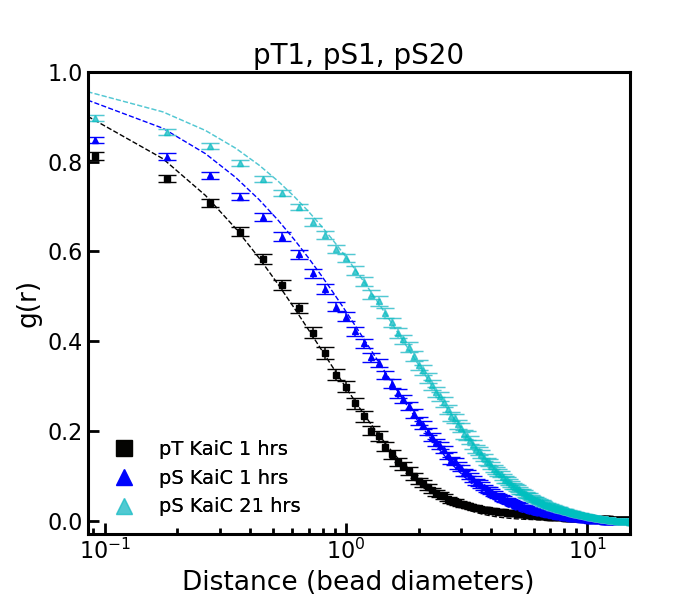

AE
EA
EA


In [177]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

marker = 'o'
markerSize = 4.5
marker2 = '--'
linew = 1.0
elinew = 1.1
cap_size = 6.5

lines1 = []                                
lines2 = []
time_arr = []

fk = 3
i=0
marker, cmap, cmap2, data_label = select_cmap(fk)
time = data_label+", "+str(time_array[i])+" hrs"
time_arr.append(time)

cmap = (matplotlib.cm.get_cmap('spring'))(0.99)
ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap, alpha=(0.01+(i*0.05)))
lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap, alpha=(0.01+(i*0.05)), label = time)
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c=cmap, alpha=(0.01+(i*0.05))) 
ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))
lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))

fk = 2
i=0
marker, cmap, cmap2, data_label = select_cmap(fk)
time = data_label+", "+str(time_array[i])+" hrs"
time_arr.append(time)
lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap, alpha=(0.02+(i*0.03)), label = time)
ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c='b', alpha=0.995)
lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c='b', alpha=0.995)
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c='b', alpha=0.995) 

fk = 2
i=6
marker, cmap, cmap2, data_label = select_cmap(fk)
time = data_label+", "+str(time_array[i])+" hrs"
time_arr.append(time)
ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap2(0.995-(i*0.122)), alpha=0.995)
lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap2(0.995-(i*0.122)), alpha=0.995)
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c=cmap2(0.995-(i*0.122)), alpha=0.995)

ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap, alpha=(0.4+(i*0.03)))
lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap, alpha=(0.4+(i*0.03)), label = time)
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c=cmap, alpha=(0.4+(i*0.03)))  

#ax.set_yscale("log")
#ax.set_ylim(0.09, 1.0)
ax.set_ylim(-0.03, 1.0)

ax.set_xscale("log")
ax.set_xlim(0.085, 15) 
#ax.set_xlim(0.085, 4.8)
#ax.set_xlim(0, 4.8)

    
title =  "pT1, pS1, pS20" #+ " (normalized CDF)"   #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('g(r)', fontsize=font_size-1)
plt.xlabel('Distance (bead diameters)', fontsize=font_size-1)

leg_loc= 'lower left' #'upper right'  #

leg1 = ax.legend(markerscale=2.5, fontsize=font_size-6, loc = leg_loc, framealpha= 0, frameon=False)
from matplotlib.legend import Legend
leg2 = Legend(ax, lines1, time_arr, markerscale=2.5, fontsize=font_size-6,
             loc=leg_loc, framealpha= 0, frameon=False)
ax.add_artist(leg2)

plt.show()

fig.savefig(data_saveto+ "logx Fig3 SIA avg + error + fits "+title+".png", dpi=800, bbox_inches ='tight')
fig.savefig(svg_saveto+ "logx Fig3 SIA avg + error + fits"+title+".svg", dpi=800, bbox_inches ='tight')
#fig.savefig(data_saveto+ "SIA avg + error "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "SIA avg + error "+title+".svg", dpi=800, bbox_inches ='tight')

#fig.savefig(data_saveto+ "all times SIA avg + error + fits "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "all times SIA avg + error + fits"+title+".svg", dpi=800, bbox_inches ='tight')
#fig.savefig(data_saveto+ "all times SIA avg + error "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "all times SIA avg + error "+title+".svg", dpi=800, bbox_inches ='tight')

<IPython.core.display.Javascript object>


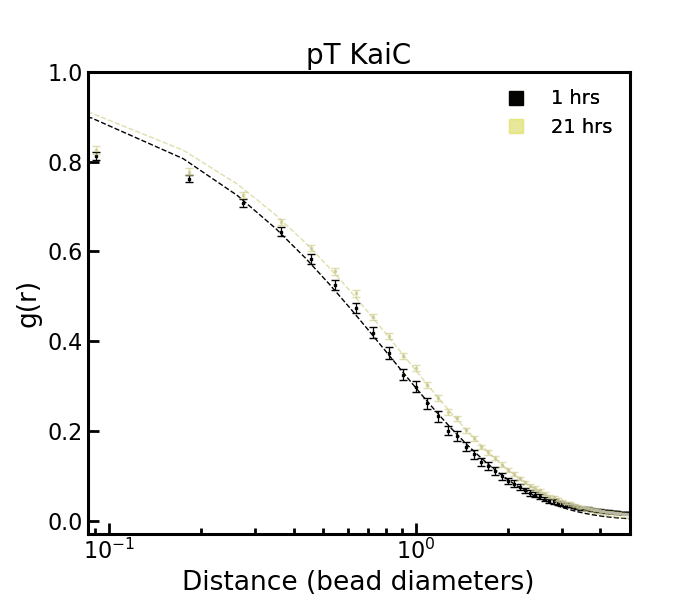

AE


In [132]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

marker = 'o'
markerSize = 2
marker2 = '--'
linew = 1.0
alpha_num = 0.99

fk = 3
#### up to 28 hrs
#WT=> 'RdPu' cmap2(0.995-(i*0.122)), alpha=0.995)    cmap, alpha=(0.02+(i*0.03))
#EA=> 'Blues'  cmap2(0.995-(i*0.122)), alpha=0.995)    cmap, alpha=(0.02+(i*0.039))
#AE=> cmap= 'spring'  cmap2= 'gist_yarg' cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09))  cmap, alpha=(0.01+(i*0.05))
marker, cmap, cmap2, data_label = select_cmap(fk)
lines1 = []                                
lines2 = []
time_arr = []
for i in range(0,7,7):
    time = str(time_array[i])+" hrs"
    time_arr.append(time)
    
    cmap = (matplotlib.cm.get_cmap('spring'))(0.99)
    ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap, alpha=(0.01+(i*0.05)))
    lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap, alpha=(0.01+(i*0.05)), label = time)
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=0.9, capsize=3, 
                c=cmap, alpha=(0.01+(i*0.05))) 
    ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))
    lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=0.9, capsize=3, 
                c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))
    
    '''ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap2(0.995-(i*0.122)), alpha=0.995)
    lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap2(0.995-(i*0.122)), alpha=0.995)
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=0.9, capsize=3, 
                c=cmap2(0.995-(i*0.122)), alpha=0.995)'''
    
    """ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap, alpha=(0.02+(i*0.03)))
    lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap, alpha=(0.02+(i*0.03)), label = time)
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=0.9, capsize=3, 
                c=cmap, alpha=(0.02+(i*0.03))) """ 

#ax.set_yscale("log")
#ax.set_ylim(0.09, 1.0)
ax.set_ylim(-0.03, 1.0)

ax.set_xscale("log")
#ax.set_xlim(0.085, 15) 
ax.set_xlim(0.085, 5)
#ax.set_xlim(0, 4.8)

    
title =  data_label #+ " (normalized CDF)"   #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('g(r)', fontsize=font_size-1)
plt.xlabel('Distance (bead diameters)', fontsize=font_size-1)


leg1 = ax.legend(markerscale=5., fontsize=font_size-6, loc = 'upper right', framealpha= 0, frameon=False)
from matplotlib.legend import Legend
leg2 = Legend(ax, lines1, time_arr, markerscale=5., fontsize=font_size-6,
             loc='upper right', framealpha= 0, frameon=False)
ax.add_artist(leg2)

plt.show()

title =  data_label + " (average g(r))"
fig.savefig(data_saveto+ "logx Fig3 SIA avg + error + fits "+title+".png", dpi=800, bbox_inches ='tight')
fig.savefig(svg_saveto+ "logx Fig3 SIA avg + error + fits"+title+".svg", dpi=800, bbox_inches ='tight')
#fig.savefig(data_saveto+ "SIA avg + error "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "SIA avg + error "+title+".svg", dpi=800, bbox_inches ='tight')

#fig.savefig(data_saveto+ "all times SIA avg + error + fits "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "all times SIA avg + error + fits"+title+".svg", dpi=800, bbox_inches ='tight')
#fig.savefig(data_saveto+ "all times SIA avg + error "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "all times SIA avg + error "+title+".svg", dpi=800, bbox_inches ='tight')

<IPython.core.display.Javascript object>


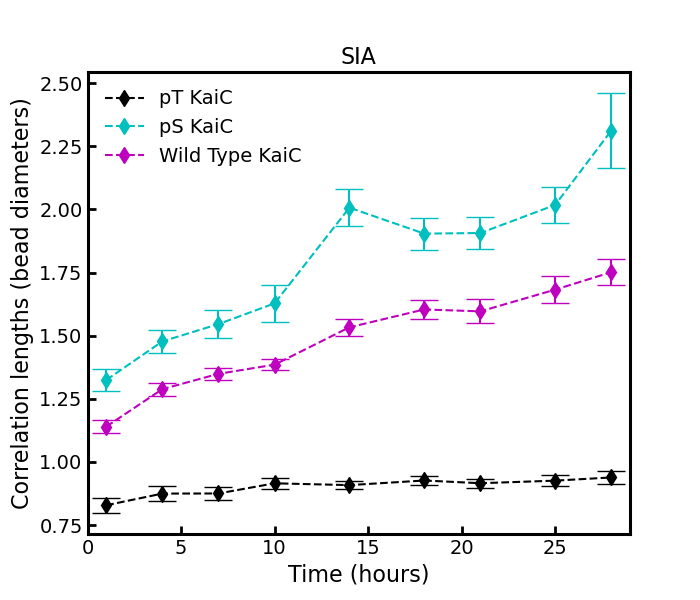

AE
EA
WT+kaiA


In [23]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=6, width=2, labelsize=font_size-6)
ax.tick_params(axis='both', direction='in', which='minor', length=3, width=2, labelsize=font_size-6)

this_plot = 'Correlation lengths (bead diameters)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = "0-28_"+this_plot

end_index = 9
y_array = all_avg_cl  #all_avg_A[fk,i], all_avg_cl[fk,i]
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array

#ax.set_ylim(2, 21)
ax.set_xlim(0, 29)
marker = '--d'
markerSize = 8
font_size = 16
cmap_num = 0.6
#threshold_details = " (clusters >= "+str(beads_per_cluster)+" beads)"
title = "SIA" 

ax.set_title(title, fontsize= (font_size))
plt.ylabel(this_plot, fontsize=font_size)
plt.xlabel('Time (hours)', fontsize=font_size)
ax.ticklabel_format(style='plain')

fk = 3
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)
fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)
fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)

plt.show()
ax.legend(fontsize=font_size-2, framealpha= 0, frameon=False)
#threshold_details = " (clusters AL "+str(beads_per_cluster)+" beads, bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
#fig.savefig(data_saveto+this_plot_s+threshold_details+".jpg", dpi=800)
#fig.savefig(svg_saveto+this_plot_s+threshold_details+".svg", dpi=800)

In [158]:
cl_array = np.zeros((num_times,18))
A_array = np.zeros((num_times,18))

In [193]:
fk = 3
all_A_vals, all_cl_vals, data_label = select_results(fk)
for i in range(num_times):
    for j in range(18):
        cl_array[i][j] = (all_cl_vals[i][j])*2
#print(cl_array[0])
new_cl_array = np.swapaxes(cl_array,0,1)
#print(new_array)

for i in range(num_times):
    for j in range(18):
        A_array[i][j] = (all_A_vals[i][j])*2
#print(cl_array[0])
new_A_array = np.swapaxes(A_array,0,1)
print(new_A_array.shape)
print(new_cl_array[0])

AE
(18, 9)
[1.46199329 1.56127868 1.54628153 1.60627851 1.64055149 1.69172029
 1.64513356 1.79203352 1.84874511]


In [194]:
csv_data_file = "New SIA results "+data_label+".csv"   
header = []
np.savetxt(data_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(data_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow([data_label])
    writer.writerow(["A values"])
    writer.writerow(["1", "4", "7", "10", "14", "18", "21", "25", "28"])
    for i in range(18):
        writer.writerow(new_A_array[i])
    writer.writerow([''])
    writer.writerow([''])
    writer.writerow(["correlation lengths"])
    writer.writerow(["1", "4", "7", "10", "14", "18", "21", "25", "28"])
    for i in range(18):
        writer.writerow(new_cl_array[i])
f.close()

<IPython.core.display.Javascript object>


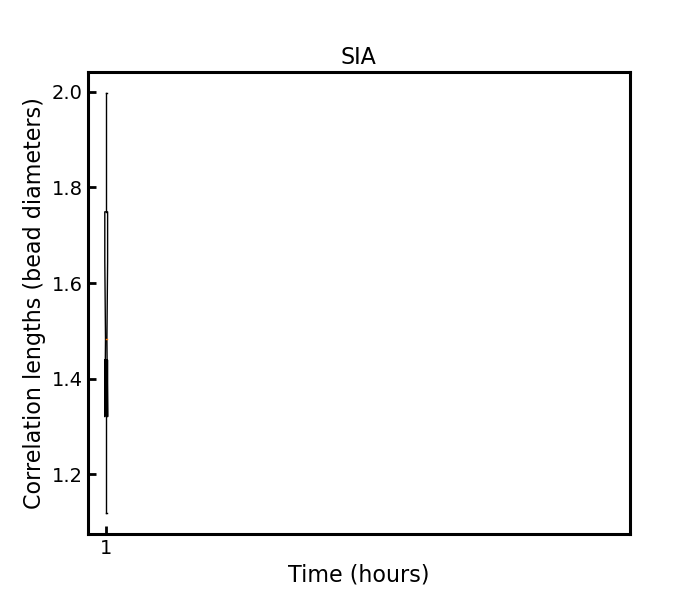

No handles with labels found to put in legend.


AE


In [112]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=6, width=2, labelsize=font_size-6)
ax.tick_params(axis='both', direction='in', which='minor', length=3, width=2, labelsize=font_size-6)

this_plot = 'Correlation lengths (bead diameters)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = "0-28_"+this_plot

end_index = 9
y_array = all_avg_cl  #all_avg_A[fk,i], all_avg_cl[fk,i]
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array

#ax.set_ylim(2, 21)
ax.set_xlim(0, 29)
marker = '--d'
markerSize = 8
font_size = 16
cmap_num = 0.6
#threshold_details = " (clusters >= "+str(beads_per_cluster)+" beads)"
title = "SIA" 

ax.set_title(title, fontsize= (font_size))
plt.ylabel(this_plot, fontsize=font_size)
plt.xlabel('Time (hours)', fontsize=font_size)
ax.ticklabel_format(style='plain')

fk = 3
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
for i in range(num_times):
    for j in range(18):
        array[i][j] = WTkA_all_t_cl_vals[i][j]
new_array = np.swapaxes(array,0,1)
ax.boxplot(new_array[0], marker)

'''fk = 3
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)
fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)
fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)'''

plt.show()
ax.legend(fontsize=font_size-2, framealpha= 0, frameon=False)
#threshold_details = " (clusters AL "+str(beads_per_cluster)+" beads, bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
#fig.savefig(data_saveto+this_plot_s+threshold_details+".jpg", dpi=800)
#fig.savefig(svg_saveto+this_plot_s+threshold_details+".svg", dpi=800)

## Now we fit the SIA curves to a single exponential, fit equation: y = e^(-x/L1) + A

<IPython.core.display.Javascript object>


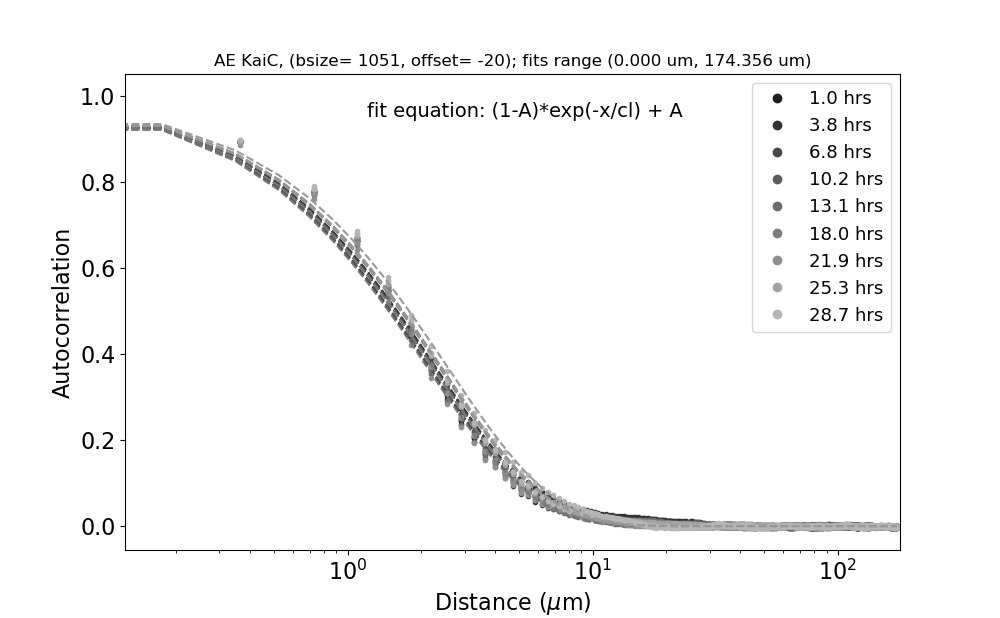

first x-value= 0.364, start fits at 0.000; fit until xlim = 174.356
Fits:
1.0 hrs-- r1 fit: A=0.001, l1=2.236
1.0 hrs-- r2 fit: A=0.001, l1=2.293
1.0 hrs-- r3 fit: A=0.001, l1=2.242
3.8 hrs-- r1 fit: A=0.002, l1=2.398
3.8 hrs-- r2 fit: A=0.001, l1=2.500
3.8 hrs-- r3 fit: A=0.001, l1=2.152
6.8 hrs-- r1 fit: A=-0.000, l1=2.298
6.8 hrs-- r2 fit: A=0.001, l1=2.291
6.8 hrs-- r3 fit: A=0.001, l1=2.246
10.2 hrs-- r1 fit: A=0.000, l1=2.281
10.2 hrs-- r2 fit: A=0.001, l1=2.436
10.2 hrs-- r3 fit: A=0.000, l1=2.251
13.1 hrs-- r1 fit: A=0.000, l1=2.172
13.1 hrs-- r2 fit: A=0.000, l1=2.087
13.1 hrs-- r3 fit: A=0.001, l1=2.236
18.0 hrs-- r1 fit: A=-0.000, l1=2.235
18.0 hrs-- r2 fit: A=-0.000, l1=2.310
18.0 hrs-- r3 fit: A=0.001, l1=2.240
21.9 hrs-- r1 fit: A=0.000, l1=2.118
21.9 hrs-- r2 fit: A=-0.000, l1=2.335
21.9 hrs-- r3 fit: A=-0.000, l1=2.229
25.3 hrs-- r1 fit: A=-0.000, l1=2.374
25.3 hrs-- r2 fit: A=-0.001, l1=2.329
25.3 hrs-- r3 fit: A=0.001, l1=2.421
28.7 hrs-- r1 fit: A=-0.000, l1=2.569
28

<ipython-input-155-38eb18675e2f>:98: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'AE KaiC, (bsize= 1051, offset= -20); fits range (0.000 um, 174.356 um)')

In [155]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

### Set up dictionary ("results_dict") and more empty arrays to save results in
results_dict = {}
results_dict["time array"] = time_array

r1_params = [0.0] * arr_length
r2_params = [0.0] * arr_length
r3_params = [0.0] * arr_length

### FIT PARAMETERS: adjust these to change the range for fitting attempts 
fit_start = 0
fit_lim = -1 
retry_num = 10 #retry_num is the number of fitting attempts to try before moving on, not very relevant to single exp fits
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits at %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[fit_start], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]

### load and plot the 3 original SIA curves corresponding to 3 tiff files associated with each time point 
    r1_y_array = r1_corr_rad_array[i]
    r2_y_array = r2_corr_rad_array[i]
    r3_y_array = r3_corr_rad_array[i]
    plt.semilogx(all_xvalues,r1_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    #plt.plot(all_xvalues,r2_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.plot(all_xvalues,r3_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
### x_fit_values has the same range as "all_xvalues", but includes more values to produce better fits
    x_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000) 

### the "curve_fit" function from scipy does the initial fitting attempt
    r1_popt, r1_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r1_y_array[fit_start:fit_lim])
    r2_popt, r2_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r2_y_array[fit_start:fit_lim])
    r3_popt, r3_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r3_y_array[fit_start:fit_lim])
    print(time+"-- "+'r1 fit: A=%5.3f, l1=%5.3f' % tuple(r1_popt))
    print(time+"-- "+'r2 fit: A=%5.3f, l1=%5.3f' % tuple(r2_popt))
    print(time+"-- "+'r3 fit: A=%5.3f, l1=%5.3f' % tuple(r3_popt))
    r1_A, r1_cl = tuple(r1_popt)
    r2_A, r2_cl = tuple(r2_popt)
    r3_A, r3_cl = tuple(r3_popt)
    
### the "check fits" function re-runs "curve_fit" with a slightly smaller range until the fit parameters meet our criteria
### specified in the "check fits" function, our fit parameters criteria was more relevant for double exponential fits
### (most single exponential fits work first try)
    #r1_A, r1_cl = check_fits(r1_A, r1_cl, r1_y_array, retry_num)
    #r2_A, r2_cl = check_fits(r2_A, r2_cl, r2_y_array, retry_num)
    #r3_A, r3_cl = check_fits(r3_A, r3_cl, r3_y_array, retry_num)
    
### generate and plot curves based on the fits 
    r1_fit_values = single_exponential(x_fit_values, *r1_popt)
    r2_fit_values = single_exponential(x_fit_values, *r2_popt)
    r3_fit_values = single_exponential(x_fit_values, *r3_popt)
    plt.plot(x_fit_values, r1_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    #plt.plot(x_fit_values, r2_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.plot(x_fit_values, r3_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
### saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["r1 y vals"] = r1_y_array
    results_dict[time]["r2 y vals"] = r2_y_array
    results_dict[time]["r3 y vals"] = r3_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["r1 fit vals"] = r1_fit_values
    results_dict[time]["r2 fit vals"] = r2_fit_values
    results_dict[time]["r3 fit vals"] = r3_fit_values
    
    results_dict[time]["r1 fit params"] = [r1_A, r1_cl]
    results_dict[time]["r2 fit params"] = [r2_A, r2_cl]
    results_dict[time]["r3 fit params"] = [r3_A, r3_cl]
    
    r1_params[i] = (r1_A, r1_cl)
    r2_params[i] = (r2_A, r2_cl) 
    r3_params[i] = (r3_A, r3_cl)
    #print("br_yarray[0] = %5.3f, br_yarray[1] = %5.3f, br_fit_values[0] = %5.3f, br_fit_values[1] = %5.3f" %(br_y_array[0], 
      #                                                                                                   br_y_array[1],
       #                                                                                                  br_fit_values[0], 
                #                                                                                         br_fit_values[1]))
print(r2_params)
print(r3_params)
plt.xlabel("Distance (scaled by bead diameter)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-3)
#plt.ylim(0.1, 1.1)
#plt.ylim(0.006, 1.01)
#plt.xlim(0, 5)
#plt.xlim(0, all_xvalues[-10]+5)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
str_equation = True
equation = single_exponential(x_fit_values, *r1_popt)
ax.text(1.2,0.95, "fit equation: " + equation, fontsize=font_size-2)
str_equation = False

title_plus = title + "; fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
title = frame_names[key]
plt.title(title, fontsize=font_size -4)

In [156]:
###save figure
fig.savefig(plot_saveto+exp+" threshold SIA fits for "+title_plus+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+exp+" threshold SIA results for "+title+".p", "wb")
#file_to_write = open(plot_saveto+ "SIA results for "+title_plus+".p", "wb")
pickle.dump(results_dict, file_to_write)

## Determine and plot the results of fitting SIA curves

[[2.23605617 2.39782078 2.29756459 2.28078996 2.17155782 2.23529665
  2.11840503 2.37394049 2.56924733]
 [2.29301109 2.50031452 2.29058824 2.43582104 2.0874297  2.30963337
  2.33511801 2.32939395 2.62342757]
 [2.24166755 2.15241882 2.24552518 2.25108369 2.23558944 2.24048962
  2.22913054 2.42129423 2.40345788]]


<IPython.core.display.Javascript object>


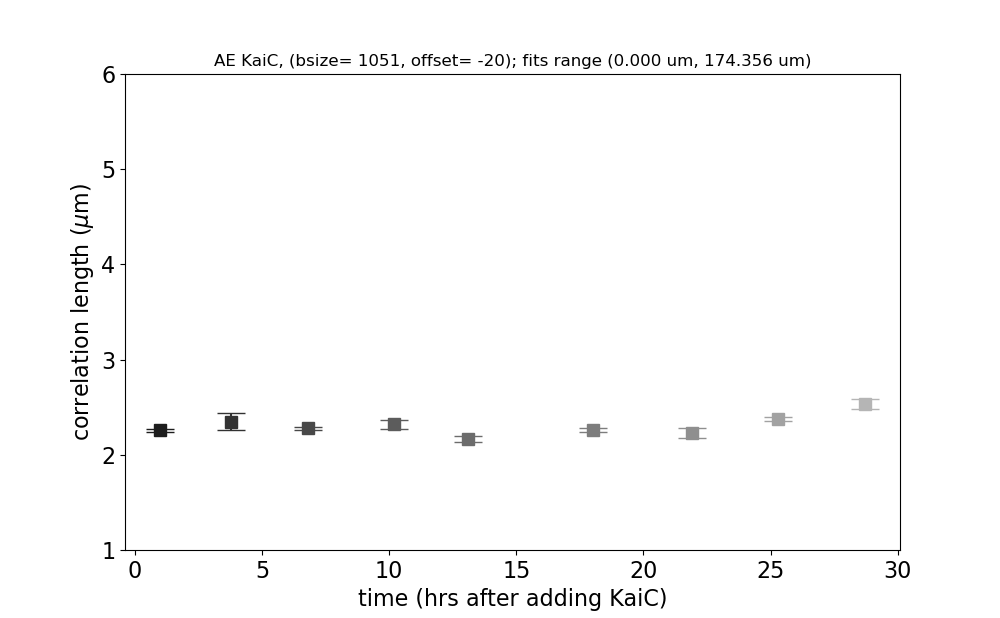

In [157]:
array_len = len(r1_params)
### set up empty arrays
all_cl = np.zeros((total_rows,array_len))
avg_cl = np.empty(array_len)
stderror_cl = np.empty(array_len)

### find average values and std. error for correlation lengths (lc) based on the fits 
for i in range(array_len):
    all_cl[0,i] = r1_params[i][1]
    all_cl[1,i] = r2_params[i][1]
    all_cl[2,i] = r3_params[i][1]
avg_cl = all_cl.mean(axis=0)
stderror_cl = (all_cl.std(axis=0))/np.sqrt(total_rows)   #
print(all_cl)
#print(all_cl.mean(axis=0))
#print(stderror_cl)

### plot average values and std. error for correlation lengths
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], avg_cl[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], avg_cl[i], yerr = stderror_cl[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
plt.xlabel("Time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("Correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(1,6)
#title_plus = title + "; n fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)
plt.show()

### save plot
fig.savefig(plot_saveto+exp+" threshold correlation lengths for "+title_plus+".jpg", dpi=dpi_num)

[[ 1.31979814e-03  1.63698855e-03 -3.97609906e-04  2.34933093e-04
   1.25406718e-04 -3.07808341e-04  6.00177153e-05 -2.49649253e-04
  -3.25343552e-04]
 [ 1.20396931e-03  1.19010037e-03  5.98056948e-04  5.99605799e-04
   1.36940429e-04 -2.65777503e-04 -1.16290834e-04 -5.03395778e-04
  -4.14411541e-04]
 [ 9.71680785e-04  1.15436274e-03  8.39786629e-04  1.15744500e-05
   5.23908761e-04  5.92518431e-04 -7.40590454e-05  6.84473530e-04
   2.50079341e-04]]


<IPython.core.display.Javascript object>


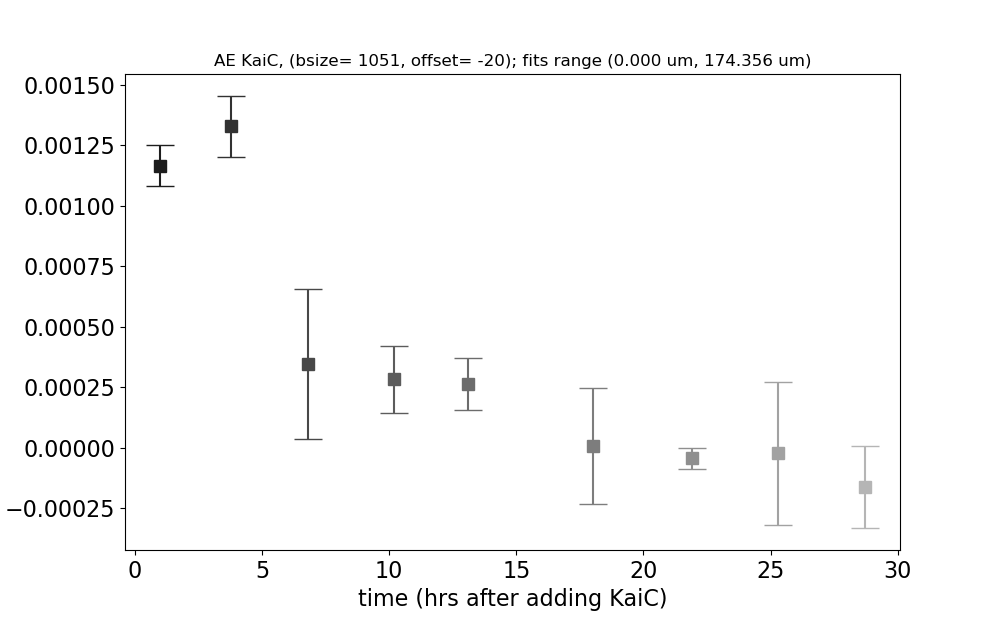

In [158]:
array_len = len(r1_params)
### set up empty arrays
all_A = np.zeros((total_rows,array_len))
avg_A = np.empty(array_len)
stderror_A = np.empty(array_len)

### find average values and std. error for correlation lengths (lc) based on the fits 
for i in range(array_len):
    all_A[0,i] = r1_params[i][0]
    all_A[1,i] = r2_params[i][0]
    all_A[2,i] = r3_params[i][0]
avg_A = all_A.mean(axis=0)
stderror_A = (all_A.std(axis=0))/np.sqrt(total_rows)   #
print(all_A)
#print(all_cl.mean(axis=0))
#print(stderror_cl)

### plot average values and std. error for correlation lengths
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], avg_A[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], avg_A[i], yerr = stderror_A[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("offset parameter (... + A) value (unitless)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
#plt.ylim(0.001,0.04)
#title_plus = title + "; n fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)
plt.show()

### save plot
fig.savefig(plot_saveto+exp+" threshold A values for "+title_plus+".jpg", dpi=dpi_num)

## Save all results to 3 seperate CSV files --> use for plotting in origin later on 

In [159]:

### first CSV file: save fit parameters (coefficient 'A' and correlation length 'L1'), and avg autocorrelation plateau values
csv_data_file = exp+" results- threshold SIA fit parameters.csv"
data_file_exists = os.path.isfile(plot_saveto+csv_data_file)
if data_file_exists:
    print(csv_data_file + " already exists.")
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['time (hrs)','','r1 A','r2 A','r3 A','','avg A', 'A std E','','','r1 cL','r2 cL','r3 cL','', 
                         'avg cL', 'cL std E'])
        for i in range(len(time_array)):
            writer.writerow([time_array[i],'', r1_params[i][0], r2_params[i][0], r3_params[i][0],'', avg_A[i], stderror_A[i],'','',
                             r1_params[i][1], r2_params[i][1], r3_params[i][1],'', avg_cl[i], stderror_cl[i]])
        writer.writerow([''])
    f.close()
    print("Results appended to "+ csv_data_file)
else:
    print(csv_data_file + " does NOT exist.")
    header = []
    np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['time (hrs)','','r1 A','r2 A','r3 A','','avg A', 'A std E','','','r1 cL','r2 cL','r3 cL','', 
                         'avg cL', 'cL std E'])
        for i in range(len(time_array)):
            writer.writerow([time_array[i],'', r1_params[i][0], r2_params[i][0], r3_params[i][0],'', avg_A[i], stderror_A[i],'','',
                             r1_params[i][1], r2_params[i][1], r3_params[i][1],'', avg_cl[i], stderror_cl[i]])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to "+ csv_data_file)

### BOX PLOTS CSV file: save fit parameters (coefficient 'A' and correlation length 'L1'), and avg autocorrelation plateau values
csv_data_file = exp+" Box Plot results- threshold SIA fit parameters.csv"
data_file_exists = os.path.isfile(plot_saveto+csv_data_file)
if data_file_exists:
    print(csv_data_file + " already exists.")
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['','A values','','','','','','','','','','','','correlation length'])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1', r1_params[0][0], r1_params[1][0], r1_params[2][0], r1_params[3][0], r1_params[4][0],
                         r1_params[5][0], r1_params[6][0], r1_params[7][0], r1_params[8][0],'','',
                         'row1', r1_params[0][1], r1_params[1][1], r1_params[2][1], r1_params[3][1], r1_params[4][1],
                         r1_params[5][1], r1_params[6][1], r1_params[7][1], r1_params[8][1],'','',])
        
        writer.writerow(['row2', r2_params[0][0], r2_params[1][0], r2_params[2][0], r2_params[3][0], r2_params[4][0],
                         r2_params[5][0], r2_params[6][0], r2_params[7][0], r2_params[8][0],'','',
                         'row2', r2_params[0][1], r2_params[1][1], r2_params[2][1], r2_params[3][1], r2_params[4][1],
                         r2_params[5][1], r2_params[6][1], r2_params[7][1], r2_params[8][1],'','',])
        
        writer.writerow(['row3', r3_params[0][0], r3_params[1][0], r3_params[2][0], r3_params[3][0], r3_params[4][0],
                         r3_params[5][0], r3_params[6][0], r3_params[7][0], r3_params[8][0],'','',
                         'row3', r3_params[0][1], r3_params[1][1], r3_params[2][1], r3_params[3][1], r3_params[4][1],
                         r3_params[5][1], r3_params[6][1], r3_params[7][1], r3_params[8][1],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("Results appended to "+ csv_data_file)
else:
    print(csv_data_file + " does NOT exist.")
    header = []
    np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['','A values','','','','','','','','','','','','correlation length'])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1', r1_params[0][0], r1_params[1][0], r1_params[2][0], r1_params[3][0], r1_params[4][0],
                         r1_params[5][0], r1_params[6][0], r1_params[7][0], r1_params[8][0],'','',
                         'row1', r1_params[0][1], r1_params[1][1], r1_params[2][1], r1_params[3][1], r1_params[4][1],
                         r1_params[5][1], r1_params[6][1], r1_params[7][1], r1_params[8][1],'','',])
        
        writer.writerow(['row2', r2_params[0][0], r2_params[1][0], r2_params[2][0], r2_params[3][0], r2_params[4][0],
                         r2_params[5][0], r2_params[6][0], r2_params[7][0], r2_params[8][0],'','',
                         'row2', r2_params[0][1], r2_params[1][1], r2_params[2][1], r2_params[3][1], r2_params[4][1],
                         r2_params[5][1], r2_params[6][1], r2_params[7][1], r2_params[8][1],'','',])
        
        writer.writerow(['row3', r3_params[0][0], r3_params[1][0], r3_params[2][0], r3_params[3][0], r3_params[4][0],
                         r3_params[5][0], r3_params[6][0], r3_params[7][0], r3_params[8][0],'','',
                         'row3', r3_params[0][1], r3_params[1][1], r3_params[2][1], r3_params[3][1], r3_params[4][1],
                         r3_params[5][1], r3_params[6][1], r3_params[7][1], r3_params[8][1],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to "+ csv_data_file)
    
### second CSV file: save raw data (x and y values) of each original SIA curve (3 curves for each time point)
csv_data_file = exp+" results- threshold SIA raw data"+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','','r1 y vals','r2 y vals','r3 y vals','','avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i],'', results_dict[time]['r1 y vals'][i],
                            results_dict[time]['r2 y vals'][i], results_dict[time]['r3 y vals'][i],'',
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

### third CSV file: save the raw data (x and y values) of each fit to each original SIA curve (3 curves for each time point)
csv_data_file = exp+" results- threshold SIA fits data"+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','','r1 fit vals','r2 fit vals','r3 fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], '', results_dict[time]['r1 fit vals'][i],
                            results_dict[time]['r2 fit vals'][i], results_dict[time]['r3 fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

results- threshold SIA fit parameters.csv already exists.
Results appended to results- threshold SIA fit parameters.csv
Box Plot results- threshold SIA fit parameters.csv already exists.
Results appended to Box Plot results- threshold SIA fit parameters.csv


## First round complete! 
## Now we can scroll back to the top and change the 'key' variable to run through the next frame (i.e. condition) of all tiff files